In [1]:
import numpy as np
import subprocess
import pandas as pd
import random
import matplotlib.pyplot as plt


# from hebo.design_space.design_space import DesignSpace
# from hebo.optimizers.hebo import HEBO

def obj(params : pd.DataFrame) -> np.ndarray:
    return ((params.values - 0.37)**2).sum(axis = 1).reshape(-1, 1)
        
# space = DesignSpace().parse([{'name' : 'x', 'type' : 'num', 'lb' : -3, 'ub' : 3}])
# opt   = HEBO(space)
# for i in range(5):
    # rec = opt.suggest(n_suggestions = 4)
    # opt.observe(rec, obj(rec))
    # print('After %d iterations, best obj is %.2f' % (i, opt.y.min()))


In [2]:
tce_fn = '../tce/count.tce'

def tcobj(params : pd.DataFrame) -> np.ndarray:
    ppa_lst = []
    for index, row in params.iterrows():
        probe_fn = 'probe.cfg'
        row.to_csv(probe_fn, header=False, index=False)
        tcsimout = subprocess.check_output(['../bin/tcsim', tce_fn, '-c', probe_fn])
        ppa = int(tcsimout.decode('utf-8').strip().split('\n')[-1])
        ppa_lst.append(ppa)
    return np.array(ppa_lst).reshape(-1,1)

space_cfg = [
    {'name' : 'div_algo', 'type' : 'int', 'lb' : 0, 'ub' : 3},
    {'name' : 'bp_init_guess', 'type' : 'int', 'lb' : 0, 'ub' : 1},
    {'name' : 'bp_wrong_tol', 'type' : 'int', 'lb' : 0, 'ub' : 16},
    {'name' : 'cache_setid_width', 'type' : 'int', 'lb' : 1, 'ub' : 5},
    {'name' : 'cache_line_width', 'type' : 'int', 'lb' : 1, 'ub' : 6},
    {'name' : 'cache_n_ways', 'type' : 'int', 'lb' : 1, 'ub' : 16},
    ]

In [3]:
col_lst = []
for d in space_cfg:
    col_lst.append(d['name']);


def randomised_search(repeats = None):
    np.random.seed(42)
    content = []

    for da in range(space_cfg[0]['lb'], space_cfg[0]['ub'] + 1):
        for big in range(space_cfg[1]['lb'], space_cfg[1]['ub'] + 1):
            for bwt in range(space_cfg[2]['lb'], space_cfg[2]['ub'] + 1):
                for csw in range(space_cfg[3]['lb'], space_cfg[3]['ub'] + 1):
                    for ciw in range(space_cfg[4]['lb'], space_cfg[4]['ub'] + 1):
                        for cnw in range(space_cfg[5]['lb'], space_cfg[5]['ub'] + 1):
                            content.append([da, big, bwt, csw, ciw, cnw])

    probe = pd.DataFrame(content, columns = col_lst)
    idc = np.random.permutation(probe.shape[0])

    idccut = probe.shape[0]
    if (repeats != None and repeats < probe.shape[0]):
        idccut = repeats
    idc = idc[0:idccut]
        
    best_cost = 99999999
    best_probe = None
    
    xdata = []
    ydata = []
    for i,l in enumerate(idc):
        cost = tcobj(probe.loc[[l]])
        if best_cost > cost:
            best_cost = cost;
            best_probe = probe.loc[[l]];
        xdata.append(i)
        ydata.append(best_cost[0][0])
            
    return xdata, ydata, best_probe

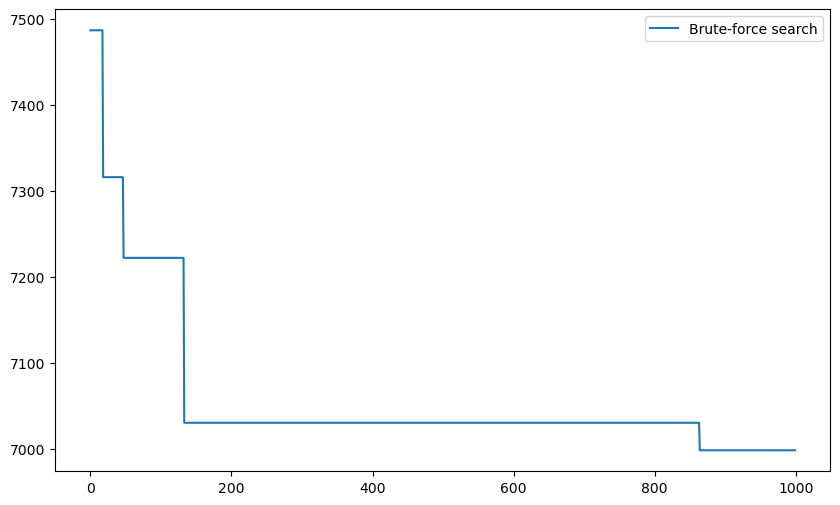

       div_algo  bp_init_guess  bp_wrong_tol  cache_setid_width  \
27904         1              1             7                  1   

       cache_line_width  cache_n_ways  
27904                 5             1  


In [13]:
nrep  = 1000
xdata, ydata, best_probe = randomised_search(nrep)
plt.figure(figsize=(10,6))
plt.xlim = ([0, nrep])
# plt.yscale('')
plt.plot(xdata, ydata, label='Brute-force search')
plt.legend()
plt.show()
plt.savefig('search.png')
plt.close()
print(best_probe)
 